# Sunspots Prediction with LSTM's

# Importing Libraries

In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#dl libraraies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

## Initial Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/CEG/Sem 7/FYP/Code/SUNSPOT NUMBER MONTHLY DATASET FROM SIDC.csv")

In [ ]:
df.head()

,YEAR,MONTH,DATE IN FRACTION,MONTHLY MEAN TOTAL,MONTHLY MEAN STANDARD DEVIATION,NUMBER OF OBSERVATIONS,DEFINITIVE / PROVISIONAL MARKER
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1


In [ ]:
df.shape

(3297, 7)

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.dtypes

YEAR                                  int64
MONTH                                 int64
DATE IN FRACTION                    float64
MONTHLY MEAN TOTAL                  float64
MONTHLY MEAN STANDARD DEVIATION     float64
NUMBER OF OBSERVATIONS                int64
DEFINITIVE / PROVISIONAL MARKER       int64
dtype: object

In [ ]:
df.isna().sum()

YEAR                                0
MONTH                               0
DATE IN FRACTION                    0
MONTHLY MEAN TOTAL                  0
MONTHLY MEAN STANDARD DEVIATION     0
NUMBER OF OBSERVATIONS              0
DEFINITIVE / PROVISIONAL MARKER     0
dtype: int64

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
YEAR,3297.0,1885.875341,79.325589,1749.000,1817.000,1886.000,1955.000,2023.000
MONTH,3297.0,6.495905,3.451387,1.000,3.000,6.000,9.000,12.000
DATE IN FRACTION,3297.0,1886.372991,79.325494,1749.042,1817.707,1886.371,1955.042,2023.705
MONTHLY MEAN TOTAL,3297.0,81.751228,67.693431,0.000,24.100,67.500,122.400,398.200
MONTHLY MEAN STANDARD DEVIATION,3297.0,5.626964,5.279562,-1.000,-1.000,5.400,9.400,29.400
NUMBER OF OBSERVATIONS,3297.0,116.037610,247.064847,-1.000,-1.000,30.000,31.000,1587.000
DEFINITIVE / PROVISIONAL MARKER,3297.0,0.998180,0.042627,0.000,1.000,1.000,1.000,1.000


In [ ]:
df.nunique()

YEAR                                 275
MONTH                                 12
DATE IN FRACTION                    3297
MONTHLY MEAN TOTAL                  1607
MONTHLY MEAN STANDARD DEVIATION      205
NUMBER OF OBSERVATIONS               393
DEFINITIVE / PROVISIONAL MARKER        2
dtype: int64

## Cleaning Data

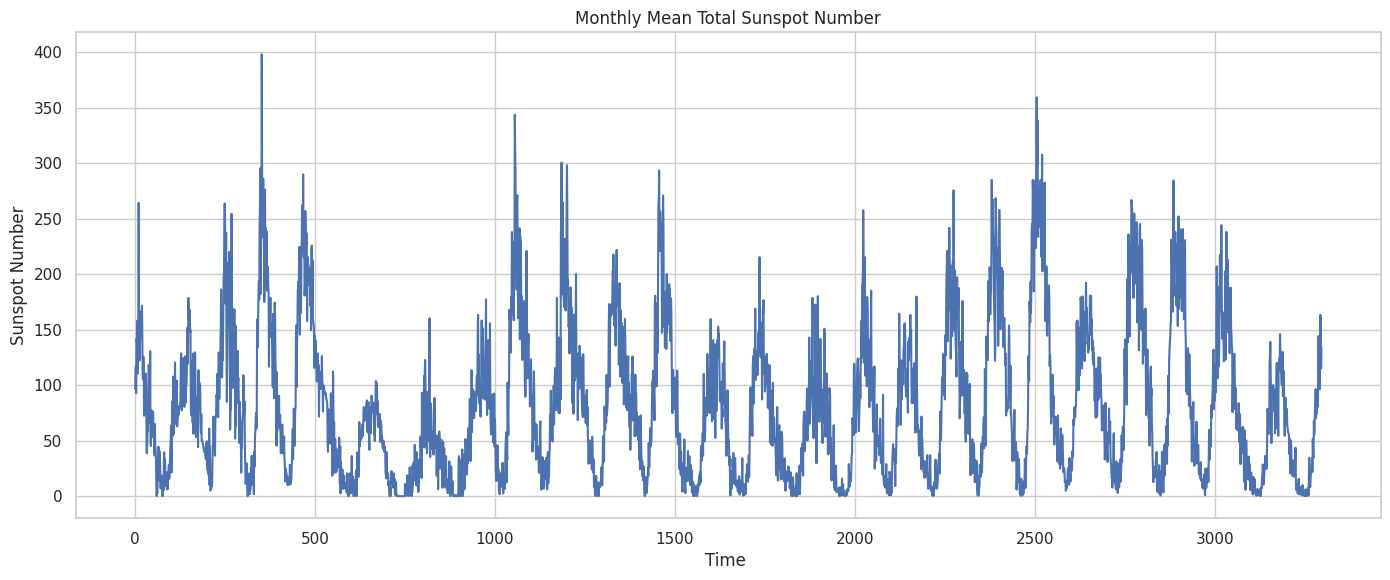

In [ ]:
plt.figure(figsize=(15,6))# Create a figure with a specified size
plt.plot(range(3297), df["MONTHLY MEAN TOTAL"])# Plot the sunspot data
plt.xlabel("Time ")# Set the x-axis label
plt.ylabel("Sunspot Number")# Set the y-axis label
plt.title("Monthly Mean Total Sunspot Number"); # Display the plot

## Defining the number of Lags

In [ ]:
stc = MinMaxScaler()# Create an instance of MinMaxScaler
stc.fit(df[["MONTHLY MEAN TOTAL"]])# Fit the scaler to the data
y = stc.transform(df[["MONTHLY MEAN TOTAL"]])# Perform the scaling transformation

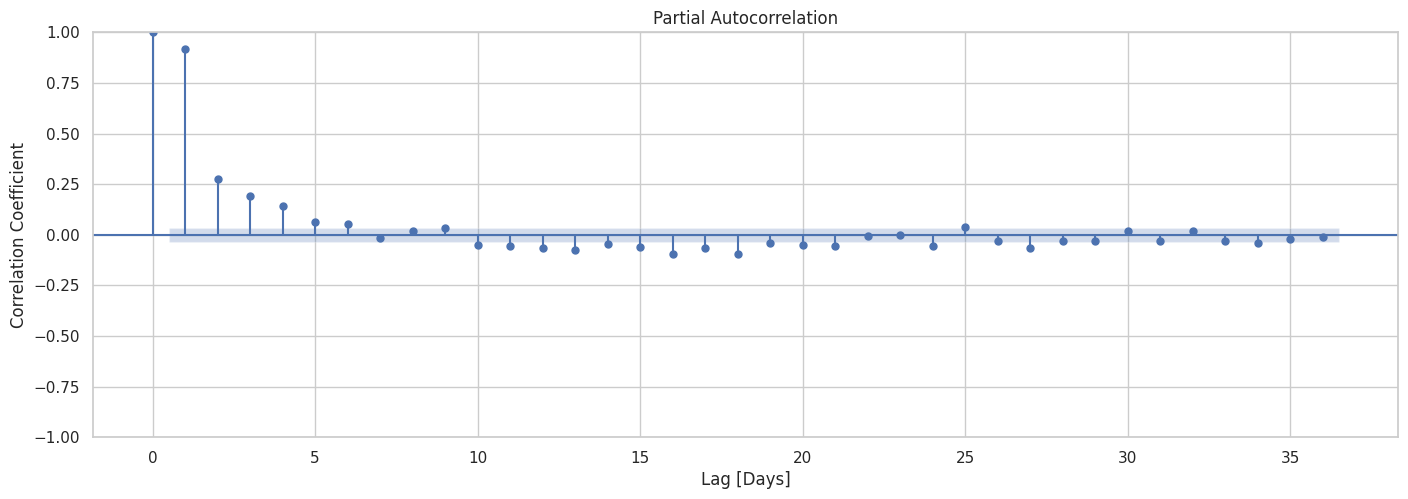

In [ ]:
df["y"] = y# Create a new column "y" in the DataFrame and assign the scaled values to it
size = int(len(y) * 0.9)# Calculate the size for the training set

fig, ax = plt.subplots(figsize=(15, 5))# Create a figure and axis objects with a specified size
plot_pacf(y, ax=ax)# Plot the partial autocorrelation function (PACF) of the "y" values
plt.xlabel("Lag [Days]")# Set the x-axis label
plt.ylabel("Correlation Coefficient");# Set the y-axis label

In [ ]:
def shift(lags):
    df_new = df.copy()# Create a copy of the DataFrame
    for i in range(1,lags+1):# Shift the "y" values by the specified number of lags
        df_new[f"y{i}"] = df_new["y"].shift(i)
    df_new.dropna(inplace=True)# Remove rows with missing values (NaN)
    X_train = df_new[:size][[f"y{i}" for i in range(1,lags+1)]]# Extract the input features (X_train) and target variable (y_train)
    y_train = df_new[:size]["y"]
    return np.array(X_train), np.array(y_train)# Convert the data to numpy arrays and return them

In [ ]:
def shift_test(lags):
    df_new = df.copy()# Create a copy of the DataFrame
    for i in range(1,lags+1):# Shift the "y" values by the specified number of lags
        df_new[f"y{i}"] = df_new["y"].shift(i)
    df_new.dropna(inplace=True)# Remove rows with missing values (NaN)
    X_train = df_new[size:][[f"y{i}" for i in range(1,lags+1)]]# Extract the input features (X_train) and target variable (y_train)
    y_train = df_new[size:]["y"]
    return np.array(X_train), np.array(y_train)# Convert the data to numpy arrays and return them

## Data Spliting

In [ ]:
X_train, y_train = shift(16)  # Obtain lagged input features (X_train) and target variable (y_train) for training data based on 16 lags.

X_test, y_test = shift_test(16)  # Obtain lagged input features (X_test) and target variable (y_test) for testing data based on 16 lags.

X_train, X_test = X_train.reshape(X_train.shape[0], 16, 1), X_test.reshape(X_test.shape[0], 16, 1)  # Reshape the input feature arrays (X_train and X_test) to have a shape of (number of samples, number of lags, 1).

# Baseline

In [ ]:
baseline_prediction = np.mean(y_train)  # Calculate the mean of y_train
y_baseline_pred = np.full_like(y_test, baseline_prediction)  # Create an array of baseline predictions

# Evaluate the performance of the baseline model
baseline_mae = mean_absolute_error(y_test, y_baseline_pred)  # Calculate the Mean Absolute Error (MAE)
baseline_mae = np.array(baseline_mae).reshape(1, -1)  # Convert MAE into a numpy array and reshape
baseline_mae = stc.inverse_transform(baseline_mae)  # Inverse transform the MAE using the MinMaxScaler
print("Baseline MAE:", baseline_mae[0][0])  # Print the Baseline MAE value

Baseline MAE: 50.18945309229551


# Models

In [ ]:
dict_results = {"Lags": [], "MAE": []}  # Create an empty dictionary to store the results for different numbers of lags.

for i in range(11, 19):
    X_train, y_train = shift(i)  # Obtain lagged input features (X_train) and target variable (y_train) for training data based on the current number of lags.
    X_test, y_test = shift_test(i)  # Obtain lagged input features (X_test) and target variable (y_test) for testing data based on the current number of lags.
    X_train, X_test = X_train.reshape(X_train.shape[0], i, 1), X_test.reshape(X_test.shape[0], i, 1)  # Reshape the input feature arrays (X_train and X_test) to match the LSTM input shape.

    model = Sequential()
    model.add(LSTM(32, input_shape=(i, 1), return_sequences=True))  # Add LSTM layer with 32 units and input shape of (number of lags, 1).
    model.add(LSTM(32, return_sequences=True))  # Add another LSTM layer with 32 units.
    model.add(LSTM(32))  # Add a third LSTM layer with 32 units.
    model.add(Dense(1))  # Add a Dense layer with 1 unit for the output.
    model.compile(loss='mean_squared_error', optimizer='adam', metrics="mae")  # Compile the model with mean squared error loss and mean absolute error metric.

    reduce_lr=ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    early_stopping =  EarlyStopping(patience=2)

    result = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=32, verbose=0, callbacks=[reduce_lr, early_stopping])  # Train the model on the training data with specified parameters.
    mae = np.array(result.history["val_mae"][-1]).reshape(1, -1)  # Obtain the final mean absolute error (MAE) from the validation set and reshape it.
    mae_inverse = stc.inverse_transform(mae)  # Inverse transform the MAE value to the original scale.
    dict_results["MAE"].append(mae_inverse[0,0])  # Store the inverse transformed MAE in the results dictionary.
    dict_results["Lags"].append(i)  # Store the current number of lags in the results dictionary.
    print(f"Finished Running The Model With {i} Lags")  # Print a message indicating the completion of training with the current number of lags.
    print(result.history["val_mae"][-1])  # Print the final MAE obtained from the validation set.
    print(dict_results)  # Print the updated results dictionary.

Finished Running The Model With 11 Lags
0.042917728424072266
{'Lags': [11], 'MAE': [17.089839458465576]}
Finished Running The Model With 12 Lags
0.04382416233420372
{'Lags': [11, 12], 'MAE': [17.089839458465576, 17.450781441479922]}
Finished Running The Model With 13 Lags
0.040294017642736435
{'Lags': [11, 12, 13], 'MAE': [17.089839458465576, 17.450781441479922, 16.045077825337646]}
Finished Running The Model With 14 Lags
0.038571201264858246
{'Lags': [11, 12, 13, 14], 'MAE': [17.089839458465576, 17.450781441479922, 16.045077825337646, 15.359052343666553]}
Finished Running The Model With 15 Lags
0.03720517084002495
{'Lags': [11, 12, 13, 14, 15], 'MAE': [17.089839458465576, 17.450781441479922, 16.045077825337646, 15.359052343666553, 14.815099028497933]}
Finished Running The Model With 16 Lags
0.047572627663612366
{'Lags': [11, 12, 13, 14, 15, 16], 'MAE': [17.089839458465576, 17.450781441479922, 16.045077825337646, 15.359052343666553, 14.815099028497933, 18.943420335650444]}
Finished Run

This code iterates over different numbers of lags, trains LSTM models for each lag configuration, records the MAE achieved by each model, and prints the results. At the end of execution, the dict_results dictionary will contain the recorded number of lags and their respective MAE values.

In [ ]:
pd.DataFrame(dict_results).sort_values("MAE")

,Lags,MAE
4,15,14.815099
3,14,15.359052
7,18,15.564775
6,17,15.841538
2,13,16.045078
0,11,17.089839
1,12,17.450781
5,16,18.943420


In [ ]:
# Create the Sequential model
model = Sequential()

# Add the first LSTM layer with 32 units and the input shape as (lags, 1)
# 'return_sequences=True' is necessary for stacking LSTM layers
model.add(LSTM(32, input_shape=(18, 1), return_sequences=True))
# Add a second LSTM layer with 32 units
model.add(LSTM(32, return_sequences=True))
# Add a second LSTM layer with 32 units
model.add(LSTM(32))
# Add a Dense output layer with 1 unit
model.add(Dense(1))

# define a learning rate schedule
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.75, patience=50, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=70, restore_best_weights=True)

# Compiling the model with the loss function 'mean_squared_error' e otimizador 'adam'
model.compile(loss='mean_squared_error', optimizer='adam', metrics="mae")

In [ ]:
result = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 200, batch_size = 32, verbose=0, callbacks=[reduce_lr, early_stopping])

In [ ]:
model.save("suns_model_lstm.h5")

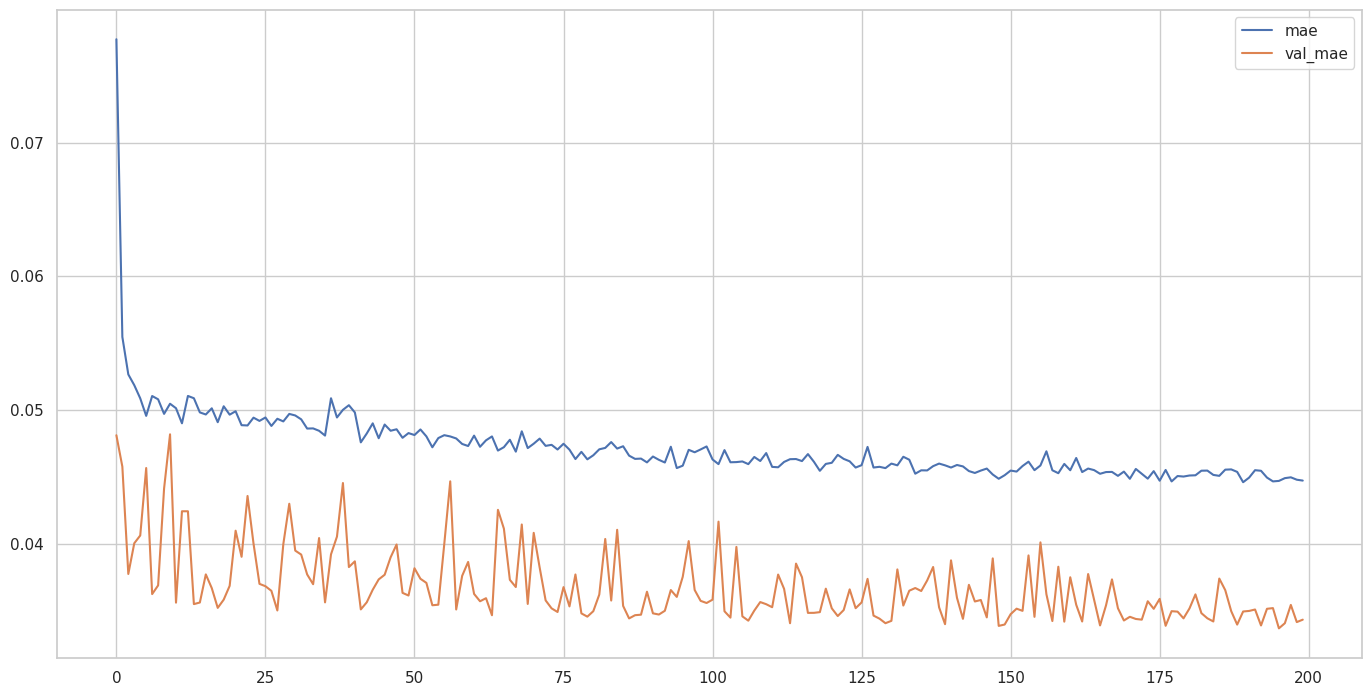

In [ ]:
pd.DataFrame(result.history)[["mae","val_mae"]].plot(figsize=(15,8));

In [ ]:
# reshape mae to have shape (1, -1)
mae = np.array(result.history["val_mae"][-1]).reshape(1, -1)

# apply inverse transform
mae_inverse = stc.inverse_transform(mae)

print("The inverse transformed MAE is: ", mae_inverse[0,0])

The inverse transformed MAE is:  13.66509534716606


In [ ]:
y_pred = model.predict(X_test)
y_pred = [x[0] for x in y_pred]

10/10 [==============================] - 1s 6ms/step


In [ ]:
y_pred = [x[0] for x in stc.inverse_transform(pd.DataFrame(y_pred))]

In [ ]:
y_test_real = [x[0] for x in stc.inverse_transform(pd.DataFrame(y_test))]

In [ ]:
mean_absolute_error(y_test_real, y_pred)

13.665095329284668

In [ ]:
plt.figure(figsize=(20, 8))  # Create a new figure with a specific size.
plt.plot(y_test_real, label="Real values")  # Plot the real values of the target variable.
plt.plot(y_pred, label="Predicted values", alpha=0.8)  # Plot the predicted values of the target variable with some transparency.
plt.legend()  # Display the legend.